In [80]:
import gym
import math
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [81]:
env = gym.make("PongDeterministic-v4")
RIGHT = 4
LEFT = 5
NOOP = 0
print(device)

cpu


In [82]:
def preprocess(frames, bg=(144,109)):
    i = np.asarray(frames)

    crop = [frame[35:195,:,:] for frame in i]
    downsample = np.asarray([frame[::2,::2,0] for frame in crop])
    for frame in downsample:
        frame[frame==bg[0]] = 0
        frame[frame==bg[1]] = 0
        frame[frame!=0] = 1

    return torch.from_numpy(downsample).float().to(device)

In [83]:
class Policy(nn.Module):

    def __init__(self):
        super(Policy, self).__init__()
        self.conv1 = nn.Conv2d(2, 4, kernel_size=6, stride=2, bias=False)
        self.conv2 = nn.Conv2d(4, 16, kernel_size=6, stride=4)
        self.size=9*9*16
        
        self.fc1 = nn.Linear(self.size, 256)
        self.fc2 = nn.Linear(256, 1)

        self.sig = nn.Sigmoid()
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(-1,self.size)
        x = F.relu(self.fc1(x))
        return self.sig(self.fc2(x))

In [87]:
def train_pong(env, policy, tmax=200, b_size=8, n_batches=30, gamma = 0.99):
    score = deque(maxlen=b_size)
    scores = []
    b=0
    
    while b<n_batches:
        states=[]
        actions=[]
        rewards=[]
        probs=[]
        
        for i_episode in range(b_size*b, (b+1)*b_size):
            env.reset()
            fr1, _, _, _ = env.step(np.random.choice([RIGHT, LEFT]))
            fr2, _, _, _ = env.step([0])
            ep_reward = []
            
            for t in range(tmax):
                x = preprocess([fr1,fr2])
                p = policy(x.unsqueeze(0))[0][0]#.cpu().detach()
                a = np.where(np.random.rand()<p, RIGHT, LEFT)
                
                fr1, r1, done, _ = env.step(a)
                fr2, r2, done, _ = env.step(NOOP)
                r = r1+r2
                
                states.append(x)
                actions.append(a)
                rewards.append(r)
                ep_reward.append(r)
                probs.append(p)
                
                if done:
                    break
        
            score.append(np.sum(ep_reward, axis=0))
            scores.append(np.sum(ep_reward, axis=0))
        
        
        discount = np.tile(gamma**np.arange(tmax), b_size)
        
        rewards = rewards*discount
        rewards = np.array(rewards).reshape(tmax, b_size)
        
        probs = torch.stack(probs)#.log()
        
        rewards_future = rewards[::-1].cumsum(axis=0)[::-1]
        r_mean = np.mean(rewards_future, axis = 1)
        r_std = np.std(rewards_future, axis = 1)+1.0e-10
        rewards_norm = (rewards_future - r_mean[:,np.newaxis])/r_std[:,np.newaxis]
        
        rewards = torch.tensor(rewards_norm, dtype=torch.float, device=device)
        rewards = torch.reshape(rewards, (tmax*b_size,1))#.cpu().detach()
        
        ##
        #states = torch.stack(states)
        #policy_input = states.view(-1,*states.shape[-3:])
        #new_probs = policy(policy_input).view(states.shape[:-3])
        ##

        L = -torch.mean(probs.log() * rewards)
        optimizer.zero_grad()
        L.backward()
        optimizer.step()
        
        print('Batch #{}/{}:\tAverage Score {:.2f}\tLoss {:.4f}'.format(b+1,
                                                                        n_batches,
                                                                        np.mean(score), L))
        
        del L
        b+=1
    
    return scores

In [96]:
#policy=Policy().to(device)
optimizer = optim.Adam(policy.parameters(), lr=1e-4)
scores = train_pong(env, policy, tmax=150, b_size=8, n_batches=30, gamma = 0.999)

Batch #1/30:	Average Score -6.00	Loss 0.0000
Batch #2/30:	Average Score -6.25	Loss 0.0000
Batch #3/30:	Average Score -6.12	Loss 0.0000
Batch #4/30:	Average Score -6.50	Loss 0.0000
Batch #5/30:	Average Score -6.12	Loss -0.0000
Batch #6/30:	Average Score -5.88	Loss 0.0000
Batch #7/30:	Average Score -5.62	Loss -0.0000
Batch #8/30:	Average Score -6.25	Loss -0.0000
Batch #9/30:	Average Score -5.88	Loss 0.0000
Batch #10/30:	Average Score -6.62	Loss -0.0000
Batch #11/30:	Average Score -6.38	Loss 0.0000
Batch #12/30:	Average Score -6.62	Loss 0.0000
Batch #13/30:	Average Score -6.88	Loss -0.0000
Batch #14/30:	Average Score -6.25	Loss 0.0000
Batch #15/30:	Average Score -5.75	Loss -0.0000
Batch #16/30:	Average Score -6.12	Loss 0.0000
Batch #17/30:	Average Score -6.25	Loss 0.0000
Batch #18/30:	Average Score -6.62	Loss 0.0000
Batch #19/30:	Average Score -6.12	Loss -0.0000
Batch #20/30:	Average Score -6.00	Loss -0.0000
Batch #21/30:	Average Score -6.62	Loss 0.0000
Batch #22/30:	Average Score -6.50	L

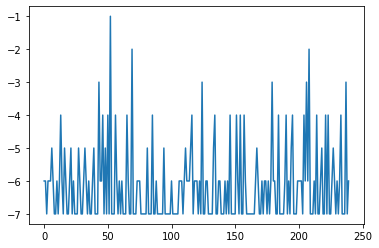

In [97]:
plt.plot(scores)

In [192]:
policy=Policy().to(device)
b=0
score = []

In [247]:

b_size = 4
tmax=200


rewards=np.zeros((tmax, b_size), dtype='float')
probs=torch.zeros((tmax, b_size), dtype=torch.float)


In [248]:

for i_episode in range(b_size*b, (b+1)*b_size):
    env.reset()

    fr1, _, _, _ = env.step(np.random.choice([RIGHT, LEFT]))
    fr2, _, _, _ = env.step([0])
    ep_r = 0

    for t in range(tmax):
        x = preprocess([fr1,fr2])
        p = policy(x.unsqueeze(0))[0][0]
        a = np.where(np.random.rand()<p, RIGHT, LEFT)

        fr1, r1, done, _ = env.step(a)
        fr2, r2, done, _ = env.step(NOOP)
        r = r1+r2

        rewards[t, i_episode%b_size] = r
        probs[t, i_episode%b_size] = p
        
        ep_r += r

        if done:
            break

    score.append(ep_r)

In [249]:
rewards_future = rewards[::-1].cumsum(axis=0)[::-1]
r_mean = np.mean(rewards_future, axis = 1)
r_std = np.std(rewards_future, axis = 1)+1.0e-10
rewards_norm = (rewards_future - r_mean[:,np.newaxis])/r_std[:,np.newaxis]

In [250]:
rewards = torch.tensor(rewards_norm, dtype=torch.float, device=device)

In [251]:
L=-torch.mean(rewards*probs.log())

In [252]:
optimizer.zero_grad()
L.backward()
optimizer.step()

In [253]:
print(np.mean(score), L)
b+=1

-8.0 tensor(1.00000e-06 *
       9.2140)


In [305]:
############
policy=Policy().to(device)
optimizer = optim.Adam(policy.parameters(), lr=2e-4)

In [306]:
b_size = 10
tmax = 150
nb = 200

b = 0
score = []
loss = []

In [307]:
while b < nb:
    rewards=np.zeros((tmax, b_size), dtype='float')
    probs=torch.zeros((tmax, b_size), dtype=torch.float)
    actions=torch.zeros((tmax, b_size), dtype=torch.float)

    for i_episode in range(b_size*b, (b+1)*b_size):
        env.reset()

        fr1, _, _, _ = env.step(np.random.choice([RIGHT, LEFT]))
        fr2, _, _, _ = env.step([0])
        ep_r = 0

        for t in range(tmax):
            x = preprocess([fr1,fr2])
            p = policy(x.unsqueeze(0))[0][0]
            a = np.where(np.random.rand()<p.item(), RIGHT, LEFT)

            fr1, r1, done, _ = env.step(a)
            fr2, r2, done, _ = env.step(NOOP)
            r = r1+r2

            rewards[t, i_episode%b_size] = r
            probs[t, i_episode%b_size] = p
            actions[t, i_episode%b_size] = a.item()

            ep_r += r

            if done:
                break

        score.append(ep_r)
        
    probs = torch.where(actions == RIGHT, probs, 1.0-probs)
    rewards_future = rewards[::-1].cumsum(axis=0)[::-1]
    r_mean = np.mean(rewards_future, axis = 1)
    r_std = np.std(rewards_future, axis = 1)+1.0e-10
    rewards_norm = (rewards_future - r_mean[:,np.newaxis])/r_std[:,np.newaxis]
    rewards = torch.tensor(rewards_norm, dtype=torch.float, device=device)
    
    L=-(rewards*probs.log()).mean()
    
    optimizer.zero_grad()
    L.backward()
    optimizer.step()
    loss.append(L)
    
    
    print('batch #{}/{}:\tscore {:.3f}\tloss{:.5f}'.format(b+1,nb, np.mean(score[-b_size:]), L  ))
    #del L
    b+=1

batch #1/200:	score -5.500	loss0.00041
batch #2/200:	score -6.000	loss-0.00042
batch #3/200:	score -6.600	loss-0.00010
batch #4/200:	score -5.300	loss-0.00004
batch #5/200:	score -6.300	loss-0.00160
batch #6/200:	score -5.500	loss0.00049
batch #7/200:	score -4.800	loss-0.00099
batch #8/200:	score -6.100	loss0.00105
batch #9/200:	score -6.100	loss-0.00169
batch #10/200:	score -6.000	loss-0.00068
batch #11/200:	score -5.900	loss-0.00010
batch #12/200:	score -5.600	loss-0.00187
batch #13/200:	score -6.000	loss0.00108
batch #14/200:	score -5.400	loss0.00048
batch #15/200:	score -5.700	loss-0.00010
batch #16/200:	score -6.300	loss-0.00432
batch #17/200:	score -6.300	loss0.00121
batch #18/200:	score -5.800	loss0.00131
batch #19/200:	score -6.000	loss-0.00100
batch #20/200:	score -6.100	loss-0.00310
batch #21/200:	score -6.000	loss-0.00050
batch #22/200:	score -6.400	loss-0.00098
batch #23/200:	score -4.400	loss-0.00161
batch #24/200:	score -6.000	loss-0.00161
batch #25/200:	score -5.100	loss

In [302]:
L.grad_fn

In [300]:
a.item()

4

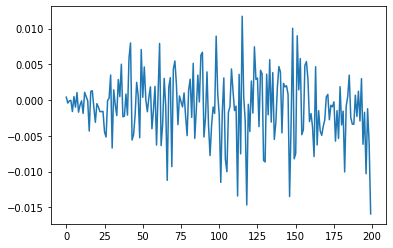

In [308]:
plt.plot(loss)

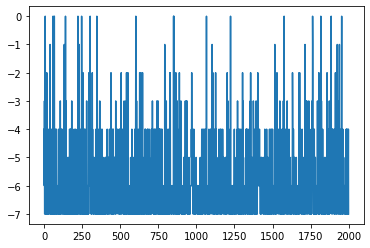

In [309]:
plt.plot(score)